In [2]:
import matplotlib
from matplotlib import pylab as plt

import time
import re
import random
random.seed(2016)

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline, grid_search
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer

In [6]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_
loc = '%s'

In [27]:
loc = '%s'
#loc = '/home/ec2-user/data/hd/features/%s'
a_o = np.load(loc % 'train_data.npy')
b_o = np.load(loc % 'test_data.npy')
a_brand = np.load(loc % 'features_brand_01_train.npy')
b_brand = np.load(loc % 'features_brand_01_test.npy')
a_other = np.load(loc % 'FEATURES_1d_TRAIN.npy')
b_other = np.load(loc % 'FEATURES_1d_TEST.npy')
a_word_feat = np.load(loc % 'SPECIAL_WORDS_FEAT_TRAIN.npy')
b_word_feat = np.load(loc % 'SPECIAL_WORDS_FEAT_TEST.npy')

a_w2vdot = pd.read_pickle(loc % 'W2V_dots_train.df').drop('relevance', axis=1).values
b_w2vdot = pd.read_pickle(loc % 'W2V_dots_test.df').drop('relevance', axis=1).values

a_w2vdist = np.load(loc % 'W2V_dists_train.npz')['arr_0']
b_w2vdist = np.load(loc % 'W2V_dists_test.npz')['arr_0']

a_w2v_el = np.load(loc % 'W2V_vecs_train.npz')['arr_0']
b_w2v_el = np.load(loc % 'W2V_vecs_test.npz')['arr_0']

In [60]:
a = np.hstack((a_o, a_brand, a_other, a_w2vdot, a_word_feat, a_w2vdist)) #, a_w2v_el))
b = np.hstack((b_o, b_brand, b_other, b_w2vdot, b_word_feat, b_w2vdist)) #, b_w2v_el))

In [61]:
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

df_a = pd.DataFrame(a, index=idx_train.index)

train_idx.shape, validation_idx.shape

((53907,), (20160,))

In [62]:
df_training_alex = df_a.loc[train_idx]
df_validating_alex = df_a.loc[validation_idx]

df_training_alex_label = idx_train.loc[train_idx]
df_validating_alex_label = idx_train.loc[validation_idx]

In [31]:
#   TRACK A
# without "co-occurring 6" features, and only limited number of features
X_train = df_training_alex.values[:, 0:100]
y_train = df_training_alex_label.values

X_test = df_validating_alex.values[:, 0:100]
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 100), (53907, 1), (20160, 100), (20160, 1))

In [63]:
#   TRACK B
# without "co-occurring 6" features
X_train = df_training_alex.values
y_train = df_training_alex_label.values

X_test = df_validating_alex.values
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 272), (53907, 1), (20160, 272), (20160, 1))

In [95]:
#   TRACK C
# with "co-occurring 6" features

coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz', index_col='id')
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz', index_col='id')

X_train = np.hstack((df_training_alex.values, coo_tra.values))
y_train = df_training_alex_label.values

X_test = np.hstack((df_validating_alex.values, coo_val.values))
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 278), (53907, 1), (20160, 278), (20160, 1))

In [1]:
clf = linear_model.Ridge (alpha = 0.6)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
fmean_squared_error(y_hat, y_test)

#0.47733228483742429
# 0.47327677738827956
# 0.4674938702127619

NameError: name 'linear_model' is not defined

In [81]:
aas = []
for i in range(150, 280):
    X_train1 = X_train[:, 0:i]
    y_train1 = y_train

    X_test1 = X_test[:, 0:i]
    y_test1 = y_test

    clf = linear_model.Ridge (alpha = 0.6)
    clf.fit(X_train1, y_train1)
    y_hat = clf.predict(X_test1)
    y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
    aas.append((i,fmean_squared_error(y_hat, y_test)))

In [75]:
aas

[(260, 0.47649325449733348),
 (261, 0.47646237592355173),
 (262, 0.47642584348415734),
 (263, 0.47636281303789491),
 (264, 0.47636362460353404),
 (265, 0.47634629974654935),
 (266, 0.47633207031469571),
 (267, 0.47634278706587102),
 (268, 0.47633912105830378),
 (269, 0.47632655882051261),
 (270, 0.47630090841251516),
 (271, 0.47610981376825984),
 (272, 0.4761270357149654),
 (273, 0.47351702100669979),
 (274, 0.47178761585910944),
 (275, 0.4692805133198405),
 (276, 0.46906775880156804),
 (277, 0.468914481369409),
 (278, 0.46855983499315912),
 (279, 0.46855983499315912)]

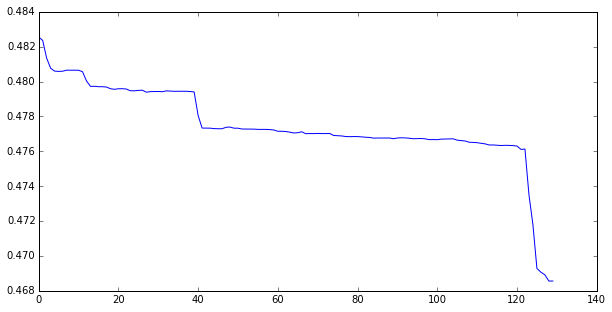

In [82]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

plt.plot([x[1] for x in aas])
plt.show()

In [97]:
aas

[(150, 0.48255078995289946),
 (151, 0.48235858373907647),
 (152, 0.48133856822257726),
 (153, 0.48075965383424951),
 (154, 0.48059944824589712),
 (155, 0.48058164037176782),
 (156, 0.48059292073013438),
 (157, 0.48065202700064408),
 (158, 0.48065285686668674),
 (159, 0.48065057988447507),
 (160, 0.48064935815621429),
 (161, 0.48056207509489712),
 (162, 0.48003085435115311),
 (163, 0.47972372909245331),
 (164, 0.47972762445888734),
 (165, 0.47970519896445923),
 (166, 0.47970315077325287),
 (167, 0.47968489178458507),
 (168, 0.4795893622899674),
 (169, 0.47955476018725074),
 (170, 0.47958705124952888),
 (171, 0.47959009417480775),
 (172, 0.47957043539039707),
 (173, 0.47947126784700078),
 (174, 0.47947004217934053),
 (175, 0.47949248759124902),
 (176, 0.47950499365347932),
 (177, 0.47938968252852715),
 (178, 0.47942255234907294),
 (179, 0.47942804232829483),
 (180, 0.47943153012091422),
 (181, 0.47941664947998014),
 (182, 0.47946445960279122),
 (183, 0.47945477584962337),
 (184, 0.479440

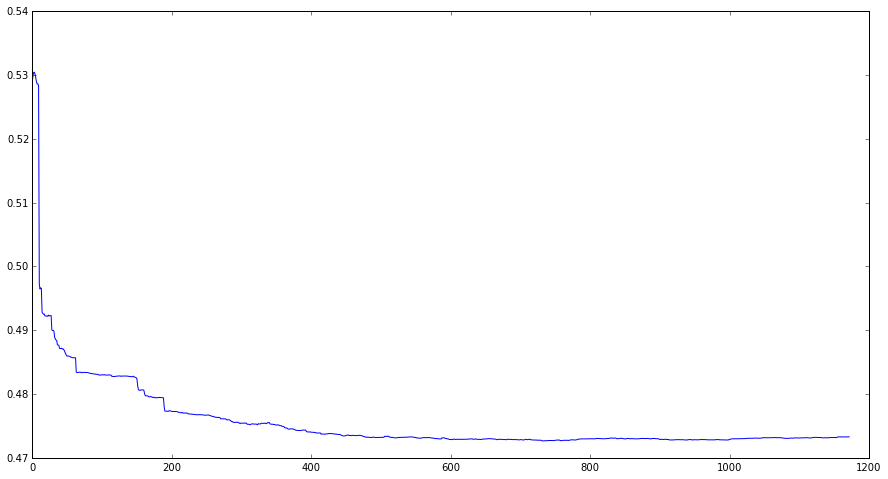

In [34]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

plt.plot(aas)
plt.show()

In [36]:
first_1172 = aas
pd.DataFrame(aas)

,0
0,0.528935
1,0.529975
2,0.530451
3,0.530449
4,0.530124
5,0.529517
6,0.528955
7,0.528607
8,0.528630
9,0.528360


In [42]:
coo_tra.shape, coo_val.shape

((53907, 7), (20160, 8))

In [44]:
coo_tra
coo_val

,relevance,orig_rel,woqt1,woqt2,woqt3,woqt4,woqt5,woqt6
0,-1,3.00,0.054131,0.139973,0.017308,0.033680,0.084147,0.010375
1,-1,2.33,0.101627,0.259178,0.012521,0.081595,0.214880,0.014222
2,-1,3.00,0.206146,1.042023,0.161459,0.010576,0.050057,0.007427
3,-1,3.00,0.250737,0.654225,0.064001,0.181117,0.467228,0.040137
4,-1,1.00,0.020699,0.052253,0.003647,0.023631,0.042638,0.000358
5,-1,1.33,0.020683,0.054795,0.001254,0.036444,0.118722,0.000749
6,-1,2.00,0.025676,0.090455,0.001537,0.011935,0.035702,0.000550
7,-1,2.67,0.111331,0.442529,0.000667,0.010946,0.034239,0.000162
8,-1,3.00,0.077544,0.163294,0.000314,0.127381,0.194105,0.000086
9,-1,2.00,0.139412,0.254918,0.022218,0.136884,0.201258,0.031163


In [22]:
a.shape, X_train.shape, y_test.shape

((74067, 191), (53907, 190), (20160, 1))

### Checked LR

In [ ]:
def next_num_round():
    return np.random.randint(750, 950)

num_round = 10000

# TRAIN AS SELF
param = {'max_depth':9, 
         'eta':0.1, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3,
         'subsample':0.9,
         'nthread':8,
         'silent': True
        }
# GOOD <<
param = {'max_depth':7, 
         'eta':0.03, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.7, #7
         'subsample':0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }
param = {'max_depth':9, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.7, #7
     'subsample':0.9,  #8
     'min_child_weight': 4.0,
     'nthread':32,
     'silent': True
    }
param = {'max_depth':6, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.6, #7
     'subsample':0.8,  #8
     'min_child_weight': 5.0,
     'nthread':32,
     'silent': True,
     'seed': 37
    }

param = {'max_depth':7, 
     'eta':0.01, # 'objective':'reg:linear',
     'eval_metric':'rmse', #'maximize': False,
     'colsample_bytree':0.6, #7
     'subsample':0.8,  #8
     'min_child_weight': 5.0,
     'nthread':32,
     'silent': True,
     'seed': 39
    }

num_round = 200000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=100, verbose_eval=10)
#bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], verbose_eval=10)

In [ ]:
# 700x trees  -  cv: 0.4377 (seed 147)
param = {'max_depth':9, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.3, #0.8 #7  0.4449
         'subsample':0.8, #0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }  
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=30, verbose_eval=10)

In [ ]:
ggX_train = xgb.DMatrix(data=a_full, label=dtrain.get_label())
ggX_test = xgb.DMatrix(data=b_full)

idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

num_round = 1550
bst = xgb.train( param, ggX_train, num_round, [(gX_test,'test')], verbose_eval=50)

y_pred = bst.predict(ggX_test)
y_pred_bounded = np.minimum(np.maximum(y_pred, 1.0), 3.0)
idx_test['relevance'] = y_pred_bounded
idx_test.to_csv('submission_RenatPawel_combined_features_xgboost_0408_0137.csv')

In [ ]:
!gzip submission_xgboost_words_0405_1646.csv

In [ ]:
# 1500 trees 
param = {'max_depth':9, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree':0.8, #0.8 #7  0.4449
         'subsample':0.9, #0.9,  #8
         'min_child_weight': 4.0,
         'nthread':32,
         'silent': True
        }  
num_round = 5000
bst = xgb.train( param, gX_train, num_round, [(gX_train,'train'),(gX_test,'test')], early_stopping_rounds=15, verbose_eval=10)

with 0.30 and 1479
cv:  0.4493

In [ ]:
loc = '%s'

aaa = pd.read_pickle(loc % 'WOQTAL_TRAIN_ALL')
bbb = pd.read_pickle(loc % 'WOQTAL_TEST_ALL')


In [ ]:
aaa.head()

In [ ]:
aaa[aaa['woqt1'] > 0.127]['relevance'].mean(), aaa[aaa['woqt1'] < 0.127]['relevance'].mean()

In [ ]:
aaa[aaa['woqt2'] > 0.329895]['relevance'].mean(), aaa[aaa['woqt2'] < 0.329895]['relevance'].mean()

In [ ]:
aaa['woqt2'].mean()

In [ ]:
bbb.head()

In [ ]:
aa = aaa.drop('relevance', axis=1)
bb = bbb.drop('relevance', axis=1)

In [ ]:
aa.reset_index().to_csv('word_co_train.csv', header=True, index=False)

In [ ]:
#bb.reset_index().to_csv('word_co_test.csv', header=True, index=False)

In [49]:
#coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz')
#coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz')
coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz', index_col='id').drop('relevance', axis=1)
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz', index_col='id').drop('orig_rel', axis=1)


In [56]:
coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz').drop('relevance', axis=1)
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz').drop('orig_rel', axis=1)

#coo_tra.to_csv('word_co_train_local.csv', index=False)
#coo_val.to_csv('word_co_validate_local.csv', index=False)

In [86]:
validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id')
train_idx = idx_train.loc[idx_train.index.difference(validation_idx.index)]


In [90]:
train_idx.to_csv('train_set.csv')

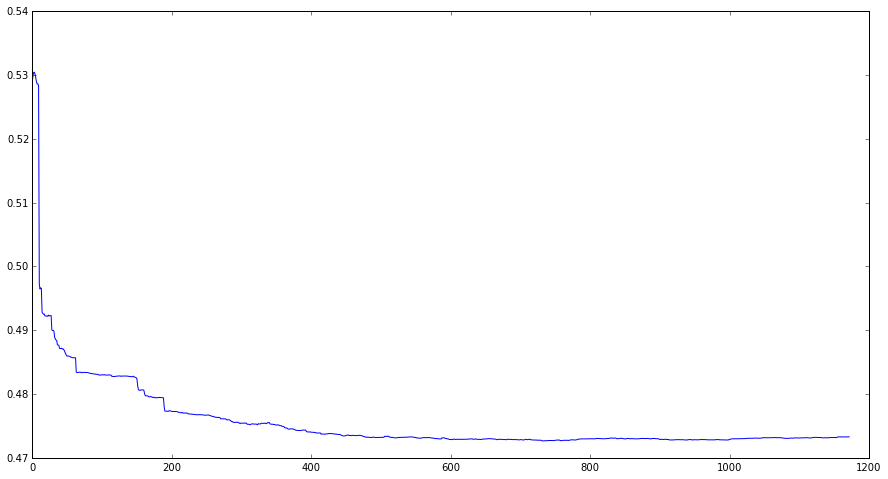

In [34]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

plt.plot(aas)
plt.show()

In [ ]:
#####

In [ ]:
TRAIN1 = pd.read_csv('./train_al_data1804.csv')
TRAIN2 = pd.read_csv('./X_train54spel.csv')
TRAIN3 =  TRAIN1.join(TRAIN2, rsuffix='_right')

In [ ]:
train_labels = pd.read_csv('~/data/kaggle/homedepot/train.csv', index_col='id').drop(['product_uid', 'product_title', 'search_term'], axis=1)

train_idx = pd.read_csv('./train_set.csv', index_col='id').drop('relevance', axis=1).join(train_labels)
validation_idx = pd.read_csv('./valid_set.csv', index_col='id').join(train_labels).drop('product_uid', axis=1)

train = train_idx.join(TRAIN3)
validate = validation_idx.join(TRAIN3)

In [ ]:
X_train_orig = train.drop('relevance', axis=1).values
y_train_orig = train.relevance.values

X_test_orig = validate.drop('relevance', axis=1).values
y_test_orig = validate.relevance.values

X_train_orig.shape, y_train_orig.shape,  X_test_orig.shape, y_test_orig.shape

In [ ]:
# WITHOUT NEW
X_train = X_train_orig
y_train = y_train_orig
X_test = X_test_orig
y_test = y_test_orig

In [ ]:
#  WITH NEW
loc = '../../%s'
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

train_idx.shape, validation_idx.shape

In [ ]:
coo_tra = pd.read_csv(loc % 'word_co_train_local.csv.gz', index_col='id')
coo_val = pd.read_csv(loc % 'word_co_validate_local.csv.gz', index_col='id')

X_train = np.hstack((X_train_orig, coo_tra.values))
y_train = y_train_orig

X_test = np.hstack((X_test_orig, coo_val.values))
y_test = y_test_orig

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

In [ ]:
clf = linear_model.Ridge (alpha = 0.6)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
fmean_squared_error(y_hat, y_test)


In [ ]:
param = {'max_depth': 7, 
         'eta':0.01, # 'objective':'reg:linear',
         'eval_metric':'rmse', #'maximize': False,
         'colsample_bytree': 0.7,
         'subsample': 1.0,
         'min_child_weight': 2.0,
         'nthread':32,
         'silent': True
        }  

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

num_round = 5000
bst = xgb.train(param, dtrain, num_round, [(dtrain, 'train'), (dtest,'test')], early_stopping_rounds=50, verbose_eval=20)

#y_pred = bst.predict(ggX_test)
#y_pred_bounded = np.minimum(np.maximum(y_pred, 1.0), 3.0)
#idx_test['relevance'] = y_pred_bounded
#idx_test.to_csv('submission_RenatPawel_combined_features_xgboost_0408_0137.csv')

In [98]:
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

df_a = pd.DataFrame(a, index=idx_train.index)

train_idx.shape, validation_idx.shape

((53907,), (20160,))

In [100]:
train_idx, validation_idx

(Int64Index([     3,      9,     17,     20,     21,     23,     27,     34,
                 37,     38,
             ...
             197124, 197127, 197133, 197136, 197139, 197141, 197144, 197146,
             197147, 197149],
            dtype='int64', name=u'id', length=53907),
 Int64Index([     2,     16,     18,     35,     69,     88,    113,    117,
                123,    136,
             ...
             221434, 221443, 221449, 221450, 221455, 221457, 221458, 221463,
             221471, 221473],
            dtype='int64', name=u'id', length=20160))

In [103]:
idx_train.loc[train_idx].shape, idx_train.loc[validation_idx].shape

((53907, 1), (20160, 1))

In [216]:
orig_train = pd.read_csv('/Users/rbekbolatov/data/kaggle/homedepot/train.csv', index_col='id')
orig_test = pd.read_csv('/Users/rbekbolatov/data/kaggle/homedepot/test.csv', index_col='id')
orig_train['matched'] = orig_train.apply(check_row, axis=1)
orig_test['matched'] = orig_test.apply(check_row, axis=1)

(1.00     2105
 1.25        4
 1.33     3006
 1.50        5
 1.67     6780
 1.75        9
 2.00    11730
 2.25       11
 2.33    16060
 2.50       19
 2.67    15202
 2.75       11
 3.00    19125
 Name: relevance, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f0b9dd0>)

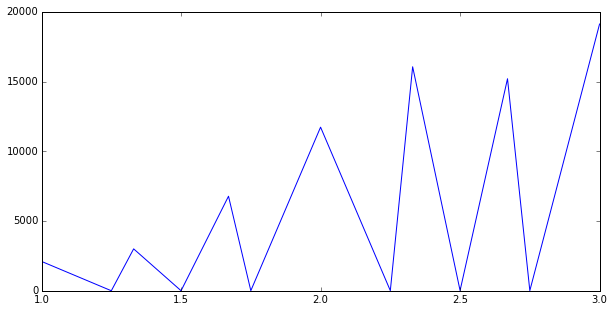

In [223]:
orig_train['relevance'].value_counts().sort_index(), orig_train['relevance'].value_counts().sort_index().plot()

In [206]:
forstack = pd.read_csv('/Users/rbekbolatov/Downloads/train_1804_10.csv')
forstack_test = pd.read_csv('/Users/rbekbolatov/Downloads/test_1804_10.csv')
fors = idx_train.reset_index().join(forstack).set_index('id')
fors = fors.join(orig_train, rsuffix='_r')

In [207]:
fors.head(5)

,relevance,alldata1804,product_uid,product_title,search_term,relevancer_,matched
id,,,,,,,
2,3.00,2.460769,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,1
3,2.50,2.209963,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,0
9,3.00,2.510892,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,0
16,2.33,2.442002,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,1
17,2.67,2.768122,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,3


In [287]:
%precision 6
def force(r):
#     x0 = r['matched']
    x = r['alldata1804']
    if x > 1.6 and x < 2.2:
        return x - 0.03
    if x > 2.4 and x < 3:
        return x + 0.014
#     if x < 2 and x >= 1.66:
#         return 1.66
    return x

def forcex(x):
    if x > 1.6 and x < 2.2:
        return x - 0.03
    if x > 2.4 and x < 3:
        return x + 0.014
#     if x < 2 and x >= 1.66:
#         return 1.66
    return x
fors['newr'] = fors.apply(force, axis=1)
#fors.head(5)
fmean_squared_error(fors['relevance'], fors['newr']), fmean_squared_error(fors['relevance'], fors['newr']) - 0.43217908068486649

(0.431896, -0.000283)

In [142]:
fors[fors['alldata1804'] < 1.3], fors['alldata1804'].min(), forstack_test['alldata1804'].min()

(        relevance  alldata1804
 id                            
 179428        2.0     1.296573
 207064        3.0     1.211936, 1.2119364738464398, 1.2266770958900501)

In [152]:
fmean_squared_error(fors['relevance'], fors['alldata1804'])

0.432179

In [293]:
submission_test = pd.read_csv('/Users/rbekbolatov/Downloads/stack10_submit_10.csv')
submission_test['relevance'].describe()

count    166693.00
mean          2.39
std           0.29
min           1.37
25%           2.19
50%           2.42
75%           2.64
max           2.95
Name: relevance, dtype: float64

In [284]:
orig_train['relevance'].describe()

count    74067.00
mean         2.38
std          0.53
min          1.00
25%          2.00
50%          2.33
75%          3.00
max          3.00
Name: relevance, dtype: float64

In [286]:
submission_test['relevance'].describe()

count    166693.00
mean          2.39
std           0.29
min           1.37
25%           2.19
50%           2.42
75%           2.64
max           2.95
Name: relevance, dtype: float64

In [288]:
submission_test['relevance'] = submission_test['relevance'].apply(forcex)

In [289]:
submission_test['relevance'].describe()

count    166693.00
mean          2.39
std           0.31
min           1.37
25%           2.16
50%           2.43
75%           2.65
max           2.97
Name: relevance, dtype: float64

In [ ]:
new_submission_test = submission_test

In [294]:
(submission_test['relevance'] - new_submission_test['relevance']).describe()

count    1.67e+05
mean     4.69e-04
std      1.83e-02
min     -1.40e-02
25%     -1.40e-02
50%     -1.40e-02
75%      3.00e-02
max      3.00e-02
Name: relevance, dtype: float64

In [299]:
new_submission_test.to_csv('AdjustedValues_Apr22_1.csv', index=False)

In [297]:
pwd

u'/Users/rbekbolatov/repos/gh/bekbolatov/kaggle/events/hd/notebooks'

In [173]:
fors['relevance'].value_counts(), fors['relevance'].describe()

(3.00    19125
 2.33    16060
 2.67    15202
 2.00    11730
 1.67     6780
 1.33     3006
 1.00     2105
 2.50       19
 2.25       11
 2.75       11
 1.75        9
 1.50        5
 1.25        4
 Name: relevance, dtype: int64, count    74067.000000
 mean         2.381634
 std          0.533984
 min          1.000000
 25%          2.000000
 50%          2.330000
 75%          3.000000
 max          3.000000
 Name: relevance, dtype: float64)

In [215]:
(2105.0 / 74067) * 0.37

0.010515

In [196]:
def check_row(r):
    qs = set(r['search_term'].lower().split()).intersection(set(r['product_title'].lower().split()))
    return len(qs)

In [228]:
%matplotlib inline
pd.set_option("display.max_rows", 300)
pd.set_option("max_colwidth", 600)
pd.set_option("precision", 2)

only_1 = orig_train[orig_train.relevance <= 1.2]
other_1 = orig_train[orig_train.relevance > 1.4]
only_1.join(fors['alldata1804']).head(50)

,product_uid,product_title,search_term,relevance,matched,alldata1804
id,,,,,,
69,100017,"MD Building Products 36 in. x 36 in. Cloverleaf Aluminum Sheet, Silver",door guards,1.0,0,1.81
178,100033,HDX 48 in. W x 72 in. H x 18 in. D Decorative Wire Chrome Finish Commercial Shelving Unit,kitchen cabinet finishes,1.0,0,2.20
195,100034,Marshalltown Masonry Brush,mortar tools,1.0,0,2.05
696,100119,Purdy 2 in. A. P. All Paints Brush Set (3-Pack),paint roller inserts,1.0,0,2.10
734,100128,Proslat 32 sq. ft. White Wall Panel Kit,garage chair organizer,1.0,0,1.93
742,100129,Sundstrom Safety Silicone Half Mask Respirator,face masks,1.0,0,2.47
764,100134,Frost King E/O 84 in. x 110 in. Patio Shrink Window Insulation Kit,plastic covers,1.0,0,1.74
867,100149,MARAZZI Montagna Gunstock 6 in. x 24 in. Glazed Porcelain Floor and Wall Tile (14.53 sq. ft. / case),funnel 6 inch,1.0,1,1.75
912,100152,Cub Cadet 42 in. and 46 in. LTX and XT1 Bagger,foof leaf broom,1.0,0,1.75


In [193]:
orig_train['matched'] = orig_train.apply(check_row, axis=1)
qqq = only_1.apply(check_row, axis=1)
qqq.head(5)

17    0
21    0
24    1
49    0
56    0
dtype: int64

In [194]:
qqq.describe()

count    5115.000000
mean        1.008798
std         0.920225
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
dtype: float64

In [195]:
other_1.apply(check_row, axis=1).describe()

count    68952.000000
mean         1.592673
std          1.104678
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         10.000000
dtype: float64

In [201]:
orig_train

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


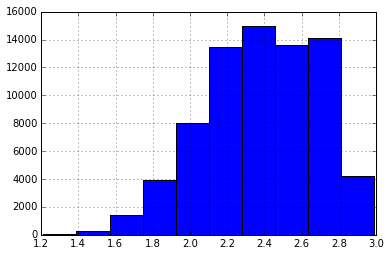

In [230]:
fors['alldata1804'].hist()

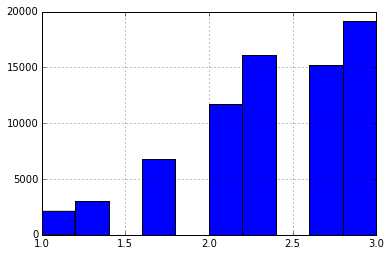

In [231]:
orig_train['relevance'].hist()

In [233]:
aaa = orig_train.join(fors['alldata1804'])
aaa['diff'] = aaa['alldata1804'] - aaa['relevance']

In [279]:
import math
aaa[(aaa['alldata1804'] > 2.4) & (aaa['alldata1804'] < 3.0)]['diff'].mean()

-0.014036

In [ ]:
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

df_a = pd.DataFrame(a, index=idx_train.index)

train_idx.shape, validation_idx.shape

In [21]:
###

In [22]:
idx_train = pd.read_pickle(loc % 'LABELS_TRAIN.df')
idx_test = pd.read_pickle(loc % 'LABELS_TEST.df')

validation_idx = pd.read_csv(loc % 'valid_set.csv.gz', index_col= 'id').index
train_idx = idx_train.index.difference(validation_idx)

In [146]:
a = pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % 1)
for i in range(2, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % i))
for i in range(1, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02db_10.csv' % i))
for i in range(1, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02dbb_10.csv' % i))
a = idx_train.reset_index().join(a).drop('relevance', axis=1).set_index('id')
    
a.tail(3)

,alldata_forstack_Apr23_xgb01,alldata_forstack_Apr23_xgb02,alldata_forstack_Apr23_xgb03,alldata_forstack_Apr23_xgb04,alldata_forstack_Apr23_xgb05,alldata_forstack_Apr23_xgb06,alldata_forstack_Apr23_xgb07,alldata_forstack_Apr23_xgb08,alldata_forstack_Apr23_xgb09,alldata_forstack_Apr23_xgb10,...,alldata_forstack_Apr23_xgb01bb,alldata_forstack_Apr23_xgb02bb,alldata_forstack_Apr23_xgb03bb,alldata_forstack_Apr23_xgb04bb,alldata_forstack_Apr23_xgb05bb,alldata_forstack_Apr23_xgb06bb,alldata_forstack_Apr23_xgb07bb,alldata_forstack_Apr23_xgb08bb,alldata_forstack_Apr23_xgb09bb,alldata_forstack_Apr23_xgb10bb
id,,,,,,,,,,,,,,,,,,,,,
221463,2.152186,2.147086,2.138218,2.124024,2.167587,2.180232,2.142887,2.137619,2.161689,2.143691,...,2.143258,2.156376,2.128822,2.154233,2.151000,2.176579,2.149602,2.140378,2.153980,2.152593
221471,2.052256,2.042717,2.046257,2.050842,2.063575,2.064392,2.040222,2.072467,2.072850,2.048585,...,2.095893,2.065787,2.055074,2.026371,2.081458,2.052094,2.062871,2.030895,2.063394,2.037393
221473,2.304186,2.318616,2.320826,2.292850,2.289202,2.273776,2.325217,2.348083,2.301293,2.317881,...,2.346110,2.315940,2.315037,2.324391,2.299013,2.335168,2.345832,2.321665,2.317483,2.327774


In [140]:
idx_train.head()

,relevance
id,
2,3.00
3,2.50
9,3.00
16,2.33
17,2.67


In [137]:
pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02dbb_10.csv' % 10).tail()

,alldata_forstack_Apr23_xgb10bb
74062,1.900246
74063,2.643234
74064,2.152593
74065,2.037393
74066,2.327774


In [72]:
b = pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02d_10.csv' % 1)
for i in range(2, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02d_10.csv' % i))
for i in range(1, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02db_10.csv' % i))
for i in range(1, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02dbb_10.csv' % i))
b = idx_test.reset_index().join(b).drop('relevance', axis=1).set_index('id')
    
b.head(3)

,alldata_forstack_Apr23_xgb01,alldata_forstack_Apr23_xgb02,alldata_forstack_Apr23_xgb03,alldata_forstack_Apr23_xgb04,alldata_forstack_Apr23_xgb05,alldata_forstack_Apr23_xgb06,alldata_forstack_Apr23_xgb07,alldata_forstack_Apr23_xgb08,alldata_forstack_Apr23_xgb09,alldata_forstack_Apr23_xgb10,...,alldata_forstack_Apr23_xgb01bb,alldata_forstack_Apr23_xgb02bb,alldata_forstack_Apr23_xgb03bb,alldata_forstack_Apr23_xgb04bb,alldata_forstack_Apr23_xgb05bb,alldata_forstack_Apr23_xgb06bb,alldata_forstack_Apr23_xgb07bb,alldata_forstack_Apr23_xgb08bb,alldata_forstack_Apr23_xgb09bb,alldata_forstack_Apr23_xgb10bb
id,,,,,,,,,,,,,,,,,,,,,
1,2.025828,2.027704,2.022876,2.017539,2.010089,2.014978,2.024598,2.028925,2.030168,2.016950,...,1.993647,1.989319,1.981671,1.975825,1.998417,1.976830,1.976478,1.985587,1.987581,2.002872
4,2.116841,2.120779,2.107031,2.111227,2.108140,2.110394,2.115723,2.105349,2.119006,2.135327,...,2.090461,2.084255,2.083595,2.082033,2.085632,2.070573,2.070257,2.063030,2.079186,2.076994
5,2.330891,2.333229,2.331932,2.328748,2.338451,2.334596,2.337623,2.331706,2.342150,2.333790,...,2.346837,2.341189,2.342168,2.341301,2.351983,2.343636,2.340139,2.345238,2.350883,2.349128


In [60]:
a.head(5)

,elapsed,mtry,nodesize,ntree,numRandomCuts,res
0,3.296322,1061,3,50,4,0.453864
1,6.706602,1061,3,100,4,0.451901
2,9.411781,1061,3,150,4,0.451254
3,12.004930,1061,3,200,4,0.450319


In [37]:
df_a = pd.DataFrame(a, index=idx_train.index)
df_b = pd.DataFrame(b, index=idx_test.index)

train_idx.shape, validation_idx.shape

((53907,), (20160,))

In [31]:
df_training_alex = df_a.loc[train_idx]
df_validating_alex = df_a.loc[validation_idx]

df_training_alex_label = idx_train.loc[train_idx]
df_validating_alex_label = idx_train.loc[validation_idx]

In [32]:
X_train = df_training_alex.values
y_train = df_training_alex_label.values

X_test = df_validating_alex.values
y_test = df_validating_alex_label.values

X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((53907, 10), (53907, 1), (20160, 10), (20160, 1))

In [33]:
clf = linear_model.Ridge (alpha = 0.6)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)
fmean_squared_error(y_hat, y_test)

0.43533488865248643

In [69]:
am = a.mean(axis=1)

In [70]:
fmean_squared_error(am, idx_train.values)

0.43125473124545166

In [73]:
am = a.mean(axis=1)
fmean_squared_error(am, idx_train.values)

0.43109642539064152

In [35]:
df_a.shape, idx_train.shape

((74067, 10), (74067, 1))

In [38]:
clf = linear_model.Ridge (alpha = 0.6)
clf.fit(df_a.values, idx_train.values)
y_hat = clf.predict(df_b.values)
y_hat = np.minimum(np.maximum(y_hat, 1.0), 3.0)

In [ ]:
idx_test['relevance'] = y_hat

In [50]:
idx_test.head(15)

,relevance
id,
1,2.006111
4,2.104020
5,2.332615
6,2.793643
7,2.454571
8,2.046158
10,2.767843
11,2.645790
12,2.261152


In [48]:
idx_test.to_csv('lr_stack_batch10.csv')

In [46]:
ttt = pd.read_csv('/Users/rbekbolatov/Downloads/stack10_submit_10.csv', encoding="ISO-8859-1")

In [51]:
ttt.head(15)

,id,relevance
0,1,2.014607
1,4,2.128223
2,5,2.318874
3,6,2.772894
4,7,2.387210
5,8,2.098128
6,10,2.768295
7,11,2.617351
8,12,2.258879
9,13,2.769060


In [54]:
a = pd.DataFrame([{ "elapsed": 3.296322 , "ntree": 50 , "numRandomCuts": 4 , "mtry": 1061 , "nodesize": 3 , "res": 0.4538638 },
{ "elapsed": 6.706602 , "ntree": 100 , "numRandomCuts": 4 , "mtry": 1061 , "nodesize": 3 , "res": 0.4519014 },
{ "elapsed": 9.411781 , "ntree": 150 , "numRandomCuts": 4 , "mtry": 1061 , "nodesize": 3 , "res": 0.4512539 },
{ "elapsed": 12.00493 , "ntree": 200 , "numRandomCuts": 4 , "mtry": 1061 , "nodesize": 3 , "res": 0.4503185 }])

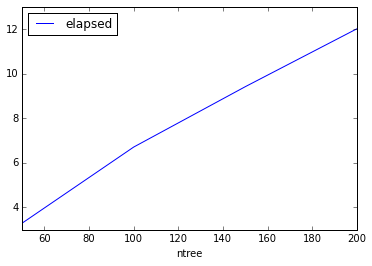

In [59]:
%matplotlib inline
a.plot(x='ntree', y='elapsed')

In [156]:
a = pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % 1)
for i in range(2, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % i))
for i in range(1, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02db_10.csv' % i))
for i in range(1, 11):
    a = a.join(pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02dbb_10.csv' % i))
a = idx_train.reset_index().join(a).drop('relevance', axis=1).set_index('id')
 
b = pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02d_10.csv' % 1)
for i in range(2, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02d_10.csv' % i))
for i in range(1, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02db_10.csv' % i))
for i in range(1, 11):
    b = b.join(pd.read_csv('forstack30xgb/test_forstack_Apr23_xgb%02dbb_10.csv' % i))
b = idx_test.reset_index().join(b).drop('relevance', axis=1).set_index('id')     
    
axgb = a
bxgb = b

a = pd.read_csv('forstack10et/train_forstack_Apr24_et%02d_10.csv' % 1)
for i in range(2, 11):
    a = a.join(pd.read_csv('forstack10et/train_forstack_Apr24_et%02d_10.csv' % i))
a = idx_train.reset_index().join(a).drop('relevance', axis=1).set_index('id')

b = pd.read_csv('forstack10et/test_forstack_Apr24_et%02d_10.csv' % 1)
for i in range(2, 11):
    b = b.join(pd.read_csv('forstack10et/test_forstack_Apr24_et%02d_10.csv' % i))
b = idx_test.reset_index().join(b).drop('relevance', axis=1).set_index('id')

aet = a
bet = b

In [157]:
fmean_squared_error(axgb.mean(axis=1), idx_train.values), fmean_squared_error(aet.mean(axis=1), idx_train.values), fmean_squared_error(axgb.join(aet).mean(axis=1), idx_train.values)

(0.43109642539064152, 0.44184175836379264, 0.43123787646370604)

In [157]:
fmean_squared_error(axgb.mean(axis=1), idx_train.values), fmean_squared_error(aet.mean(axis=1), idx_train.values), fmean_squared_error(axgb.join(aet).mean(axis=1), idx_train.values)

(0.43109642539064152, 0.44184175836379264, 0.43123787646370604)

In [ ]:
bxgb.join(bet).mean(axis=1).to_csv('combined_xgb_et.csv')

In [82]:
a = pd.read_csv('forstack10et/train_forstack_Apr24_et10_10.csv')
a1 = pd.read_csv('forstack10et/train_forstack_Apr24_et06_10.csv')
fmean_squared_error(a, idx_train.values), fmean_squared_error(a1, idx_train.values), fmean_squared_error(a1.join(a).mean(axis=1), idx_train.values)

(0.4428099187957229, 0.44283622827943514, 0.44230079135333533)

In [79]:
a = pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % 10)
fmean_squared_error(a, idx_train.values)

0.43162440284598519

In [88]:
a.columns

Index([u'alldata_forstack_Apr23_xgb10'], dtype='object')

In [142]:
#a = pd.read_csv('forstack10et/train_forstack_Apr24_et10_10.csv')
a = pd.read_csv('forstack30xgb/train_forstack_Apr23_xgb%02d_10.csv' % 10)
a = idx_train.reset_index().join(a).drop('relevance', axis=1).set_index('id')

a1 = pd.read_csv('forstack10et/train_forstack_Apr24_et06_10.csv')
a1 = idx_train.reset_index().join(a1).drop('relevance', axis=1).set_index('id')


In [147]:
am = a.mean(axis=1)

In [148]:
am.shape, a1.shape #a1

((74067,), (74067, 1))

In [129]:
a

,alldata_forstack_Apr23_xgb01,alldata_forstack_Apr23_xgb02,alldata_forstack_Apr23_xgb03,alldata_forstack_Apr23_xgb04,alldata_forstack_Apr23_xgb05,alldata_forstack_Apr23_xgb06,alldata_forstack_Apr23_xgb07,alldata_forstack_Apr23_xgb08,alldata_forstack_Apr23_xgb09,alldata_forstack_Apr23_xgb10,...,alldata_forstack_Apr23_xgb01bb,alldata_forstack_Apr23_xgb02bb,alldata_forstack_Apr23_xgb03bb,alldata_forstack_Apr23_xgb04bb,alldata_forstack_Apr23_xgb05bb,alldata_forstack_Apr23_xgb06bb,alldata_forstack_Apr23_xgb07bb,alldata_forstack_Apr23_xgb08bb,alldata_forstack_Apr23_xgb09bb,alldata_forstack_Apr23_xgb10bb
id,,,,,,,,,,,,,,,,,,,,,
2,2.412866,2.381207,2.359770,2.410638,2.365821,2.437590,2.406972,2.365507,2.405926,2.400345,...,2.380521,2.373065,2.386929,2.359443,2.374137,2.380218,2.407616,2.386109,2.404451,2.379854
3,2.118175,2.135094,2.195853,2.174051,2.169131,2.159884,2.129504,2.139326,2.129440,2.137055,...,2.159755,2.106498,2.123859,2.110083,2.127726,2.102374,2.106141,2.110141,2.121387,2.135365
9,2.548450,2.534867,2.468513,2.456058,2.518468,2.457719,2.496584,2.485906,2.486689,2.473356,...,2.495417,2.507501,2.440594,2.467501,2.503543,2.472228,2.441627,2.471210,2.456085,2.453773
16,2.371915,2.433755,2.413404,2.413744,2.410391,2.452631,2.387734,2.420532,2.430697,2.389849,...,2.416367,2.392794,2.406458,2.425651,2.415034,2.414905,2.425041,2.412584,2.421909,2.408561
17,2.785368,2.777553,2.768337,2.772614,2.774212,2.764234,2.772860,2.773728,2.777163,2.767461,...,2.773951,2.780686,2.767064,2.757564,2.777294,2.774965,2.755692,2.775924,2.766158,2.768726
18,2.611716,2.616769,2.600132,2.619038,2.645406,2.568586,2.627975,2.619385,2.583506,2.622446,...,2.610609,2.603127,2.588686,2.576421,2.599157,2.588989,2.591816,2.607627,2.577624,2.572983
20,2.637958,2.629152,2.644466,2.608408,2.631791,2.634140,2.620760,2.637509,2.657083,2.630540,...,2.618146,2.611137,2.638101,2.632947,2.628493,2.623656,2.619868,2.622991,2.625710,2.611084
21,2.883523,2.876330,2.858516,2.877153,2.841357,2.827494,2.843457,2.839177,2.859097,2.867022,...,2.860299,2.864689,2.842417,2.865787,2.874806,2.842689,2.867653,2.843335,2.863612,2.847705
23,2.791224,2.804917,2.822145,2.818886,2.793755,2.809437,2.804203,2.816718,2.807354,2.796013,...,2.797747,2.797116,2.799960,2.794633,2.816597,2.815108,2.809146,2.803080,2.805518,2.800956


In [128]:
pd.DataFrame(am, columns=['sdf'])  #.join(a1)

,sdf
id,
2,2.410281
3,2.145644
9,2.489298
16,2.407419
17,2.774473
18,2.612225
20,2.636371
21,2.852443
23,2.809749


In [143]:
fmean_squared_error(a, idx_train.values), fmean_squared_error(a1, idx_train.values)

(0.43162440284598519, 0.44283622827943514)

In [153]:
ps = np.linspace(0.6, 1.0, 10)
ys = [fmean_squared_error(pd.DataFrame(a).join(a1).apply(lambda r: r['alldata_forstack_Apr23_xgb10']*p + r['alldata_forstack_Apr24_et06']*(1.0-p), axis=1), idx_train.values) for p in ps]

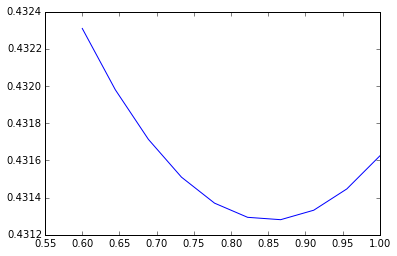

In [145]:
plt.plot(ps, ys)

In [149]:
fmean_squared_error(am, idx_train.values), fmean_squared_error(a1, idx_train.values)

(0.43109642539064152, 0.44283622827943514)

In [154]:
ps = np.linspace(0.6, 1.0, 10)
mys = [fmean_squared_error(pd.DataFrame(am, columns=['sdf']).join(a1).apply(lambda r: r['sdf']*p + r['alldata_forstack_Apr24_et06']*(1.0-p), axis=1), idx_train.values) for p in ps]

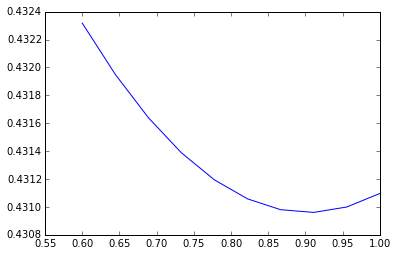

In [151]:
plt.plot(ps, mys)

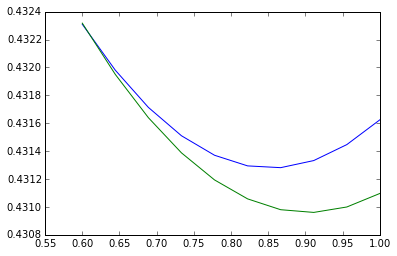

In [155]:
plt.plot(ps, ys)
plt.plot(ps, mys)

In [158]:
ps = np.linspace(0.6, 1.0, 10)
myss = [fmean_squared_error(pd.DataFrame({'sdf': axgb.mean(axis=1), 'sdf2': aet.mean(axis=1)}).apply(lambda r: r['sdf']*p + r['sdf2']*(1.0-p), axis=1), idx_train.values) for p in ps]

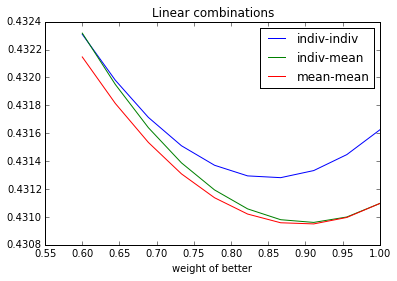

In [176]:
plt.plot(ps, ys)
plt.plot(ps, mys)
plt.plot(ps, myss)
plt.legend(['indiv-indiv', 'indiv-mean', 'mean-mean'])
plt.title("Linear combinations")
plt.xlabel('weight of better')

In [161]:
ps, ys, mys, myss

(array([ 0.6       ,  0.64444444,  0.68888889,  0.73333333,  0.77777778,
         0.82222222,  0.86666667,  0.91111111,  0.95555556,  1.        ]),
 [0.43230936508517215,
  0.43197960520639439,
  0.43171308251100904,
  0.4315099141746333,
  0.43137018971389152,
  0.4312939707897101,
  0.43128129107146407,
  0.43133215616267223,
  0.43144654358862117,
  0.43162440284598519],
 [0.43231720630210191,
  0.43194934459093481,
  0.4316393280338528,
  0.43138728134216908,
  0.43119330617178331,
  0.43105748091897528,
  0.43097986056237703,
  0.43096047655186798,
  0.43099933674491198,
  0.43109642539064152],
 [0.4321465733802996,
  0.43181312954400036,
  0.43153370186908124,
  0.43130839534036758,
  0.43113729480680851,
  0.43102046482224415,
  0.43095794952388827,
  0.4309497725490587,
  0.43099593699052086,
  0.43109642539064152])

In [168]:
p=0.9
mixed = pd.DataFrame({'sdf': bxgb.mean(axis=1), 'sdf2': bet.mean(axis=1)}).apply(lambda r: r['sdf']*p + r['sdf2']*(1.0-p), axis=1)
mixed.to_csv('combined_xgb_et.csv', header=True)

In [167]:
mixed.to_csv?